6.3510707169999705


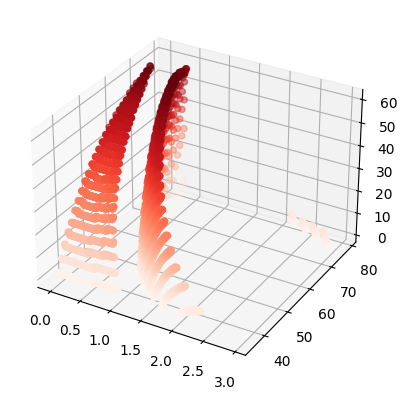

3058


In [39]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, pi, sqrt
import math
import time
global g
# Gravity, 10 is used for debugging
g = -9.81

def getPathOnXYFunction(funcs, delta_t = 0.01):
  '''
    Funcs - An array of two functions, the first one will return the x component of an objects trajectory at time point t, and the second will return the y component of an objects trajectory at time point t. It will run these function until the object hits the ground.

    Returns an array of x positions, y positions, and the time it took to hit the ground
  '''

  # Get the x and y functions out of the functions array so that we can more intuitively refer to them
  xFunc = funcs[0]
  yFunc = funcs[1]

  # Start off time at delta time (no need to compute the x and y positions at t=0 because we know that it will start on the group)
  t = delta_t

  # Create an array to store the x and y positions, initialize the array with the x and y positions at the first timestep
  x = [xFunc(t)]
  y = [yFunc(t)]
  
  # Run the functions until the y x of the function is less than 0 (the object has hit the ground)
  while y[-1] > 0 and x[-1] > 0:
    t += delta_t
    x.append(xFunc(t))
    y.append(yFunc(t))
  return x, y, t

def returnXYFuncs(theta, v_i):
  '''This will return two funcions, for the x and y component of the objects path, depending upon the objects initial launch angle (theta) and initial velocity'''
  return returnXFunc(theta, v_i), returnYFunc(theta, v_i)

def returnXFunc(theta, v_i):
  '''Returns the x component of the objects trajecotry using the following formula'''
  return lambda t: cos(theta) * v_i * t

def returnYFunc(theta, v_i):
  ''' Returns the x component of the objects trajecotry using the following formula.'''
  # NOTE: This function is assuming that you live on earth and thus acceleration is gravity
  return lambda t: (1/2 * g * t * t + sin(theta) * v_i * t)

def calculateRequiredInitialVelocityToPassThroughAPoint(coords):
  '''
  This is a function that I derived in order to calculate the required initial velocity for an object to pass through a point.
  The formula for this equation is:

         ______________________________________________
         |         ____________________________________
   v_i = |-2gy + __|((2gy)^2 - (4 * -(g^2 * x^2)))
         |----------------------------------------------
       __|                      2

  '''
  x = coords[0]
  y = coords[1]

  w = 2 * g * y
  q = - g * g * x * x

  squareRoot = sqrt((w * w) - (4 * q))
  expression = (-w + squareRoot)/2

  return (sqrt(expression))

def getThetaForPathToHitPoint(v_i, point, sizeOfPoint = 0.05):
  '''This function, when given the initial velocity required, will output the angle needed to shoot at.
    point - point we want to hit
    sizeOfPoint - the tolerance at which we can hit the point, at extereme initial velocities, this needs to be very high
  '''
  theta = 0
  go = True
  iterations = 0
  minimum_distance = 0

  # How this works is that it plots the trajectory of the object at changing angles of being shot, and it returns the correct angle once it is hit. This can be optimized by a hell of a lot and there is probably a mathetmatical formula that you can use to get the correct point in like 2 milliseconds buuuuuuut I already made a very good formula before that used a lot of brain power and Winter break was almost over so I settled on this solution, if I need to run this formula on a system that actually shoots things and is very time sensitive, then I will fix this, but otherwise there isn't a need to fix it. 
  while go:
    new_theta_1 = theta + (pi / 4) * 2 ** (-iterations)
    new_theta_2 = theta - (pi / 4) * 2 ** (-iterations)

    # Run a simulation for both new theta angles

    _x, _y, _t = getPathOnXYFunction(returnXYFuncs(new_theta_1, v_i))
    minimum_distance_theta_1 = float('inf')

    # Find the point that is the closest to the point we want to hit
    for x, y in zip(_x, _y):
      distance = sqrt((x - point[0])**2 + (y - point[1])**2)
      minimum_distance_theta_1 = min(minimum_distance_theta_1, distance)
    
    _x, _y, _t = getPathOnXYFunction(returnXYFuncs(new_theta_2, v_i))
    minimum_distance_theta_2 = float('inf')

    # Find the point that is the closest to the point we want to hit
    for x, y in zip(_x, _y):
      distance = sqrt((x - point[0])**2 + (y - point[1])**2)
      minimum_distance_theta_2 = min(minimum_distance_theta_2, distance)
    
    # If the new theta angles are closer to the point we want to hit, then we will use those angles
    if minimum_distance_theta_1 < minimum_distance_theta_2:
      minimum_distance = minimum_distance_theta_1
      theta = new_theta_1
    else:
      minimum_distance = minimum_distance_theta_2
      theta = new_theta_2

    print("Minimum distance: ", minimum_distance, "theta: ", theta)
    
    # If the point we want to hit is within the tolerance, then we are done
    if minimum_distance < sizeOfPoint:
      go = False

    iterations += 1
    if iterations > 50:
      print("Reached maximimum iterations!", theta)
      go = False

  return theta
      

def getMinViAndThetaForPoint(point, plot = False, sizeOfPoint = 0.1):
  '''This function will get the minimum initial velocity and angle at which you need to shoot the object at for a specific point, if you want to plot that then set plot to True.'''
  
  # Add a little bit of velocity because this current number is the minimum required
  v_i = calculateRequiredInitialVelocityToPassThroughAPoint(point)
  
  theta = getThetaForPathToHitPoint(v_i, point, sizeOfPoint=0.01)
  sizeOfPoint = ((v_i * v_i)/(2 * g)) / 100
  if plot:
    _x, _y, _t = getPathOnXYFunction(returnXYFuncs(theta, v_i))
    # plt.plot(_x,_y, label = "Path of Object")
    # plt.plot(point[0], point[1], 'ro', label = "Goal")
    # plt.xlabel("X Position Of Object (m)")
    # plt.ylabel("Y Position Of Object (m)")
    # plt.title("Path of Object Towards A Goal Point")
    # plt.legend()
  plt.show()
  return v_i, theta


def solveForTimeY(angle, velocity, y):
  b = sin(angle) * velocity
  
  radicand = (b * b - 4 * (1/2 * g) * -y)
  if radicand < 0:
    return [-1, -1]
  radicand = sqrt(radicand)

  t1 = (-b + radicand) / (2 * (1/2 * g))
  t2 = (-b - radicand) / (2 * (1/2 * g))

  return t1, t2

def solveForTimeX(angle, velocity, x):
  a = cos(angle) * velocity
  return x / a

def returnSolutions(angle, velocity, delta_x, delta_y, goal_height, goal_length):
  min_y = goal_bottom
  max_y = goal_top

  min_x = delta_x - goal_length / 2
  max_x = delta_x + goal_length / 2

  y1 = (solveForTimeY(angle, velocity, min_y))
  y2 = (solveForTimeY(angle, velocity, max_y))

  x1 = (solveForTimeX(angle, velocity, min_x))
  x2 = (solveForTimeX(angle, velocity, max_x))

  time_solutions = [[[x1, x2], [y1[0], y2[0]]], [[x1, x2], [y2[1], y1[1]]]]

  solutions = []

  # plotTrajectoryOfObject(angle, velocity, (delta_x, delta_y))
  
  
  for x, y in time_solutions:
    # If both time solutions are negative then this won't work
    # if y[0] == -1 and y[1] == -1:
    #   continue
    # if y[0] == -1 and y[1] > x[0]:
    #   y[0] = x[0]
    # if y[1] == -1 and y[0] < x[1]:
    #   y[1] = x[1]  

    

    # Check to see if any time solutions have an overlap area
    # if (max(y) >= max(x) and min(y) >= min(x)) or (max(y) > min(x) and min(x) >= min(y)) or (max(y) >= max(x) and min(y) >= min(x)) or (max(y) > min(x) and min(x) >= min(y)):
     
    
    # Check to see if the disc starts above the goal while having a negative y velocity
    # if SIN_ANGLE * velocity + g * min(x) < 0 and SIN_ANGLE * velocity * min(x) + g * min(x) ** 2 / 2 < goal_top:
    #   continue
    # Check to see if the disc starts underneath the wall of the goal
    if not (y[0] == -1 or y[1] == -1):
      if SIN_ANGLE * velocity * min(x) + g * (min(x) ** 2) / 2 < goal_top:

          


        # Check to see if the disc ends up above the goal
          if SIN_ANGLE * velocity * max(x) + g * max(x) ** 2 / 2 < goal_bottom + goal_height + 0.02 or (SIN_ANGLE * velocity * max(x) + g * max(x) ** 2 / 2 > goal_top and SIN_ANGLE * velocity * min(x) + g * (min(x) ** 2) / 2 > goal_bottom + goal_height + 0.02):
            

            # if SIN_ANGLE * velocity * min(x) + (1/2 * g) * min(x) * min(x) > max_y:
            #   continue
            
            # if SIN_ANGLE * velocity * max(x) + (1/2 * g) * max(x) * max(x) < SIN_ANGLE * velocity * min(x) + (1/2 * g) * min(x) * min(x):
            #   continue

            # Check to see if the velocity of the disc is negative when shooting
            # if SIN_ANGLE * velocity + g * max(x) > 0:
            #   continue
            # print("Minimum x position: ", min(x) * velocity * COS_ANGLE, "Maximum x position: ", max(x) * velocity * COS_ANGLE)
            # print("Minimum y position: ", min(y) * velocity * SIN_ANGLE + (1/2 * g) * (min(y) * min(y)), "Maximum y position: ", max(y) * velocity * SIN_ANGLE + (1/2 * g) * (max(y) * max(y)))

            # print("Minimum x time: ", min(x), "Maximum x time: ", max(x))
            # print("Minimum y time: ", min(y), "Maximum y time: ", max(y))
            if max(y) >= max(x) and min(y) >= min(x):
              solutions.append([min(x), max(x)])
            elif max(y) > min(x) and min(x) >= min(y):
              solutions.append([min(x), max(y)])
            
            elif max(y) >= max(x) and min(y) >= min(x):
              solutions.append([min(x), max(x)])
            elif max(y) > min(x) and min(x) >= min(y):
              solutions.append([min(x), max(y)])
            else:
              pass
  return solutions

def computeSolutionsForPosition(angle, delta_x, delta_z):
  v_disk_i = calculateRequiredInitialVelocityToPassThroughAPoint((delta_x, delta_z))

  returnYFunc(v_disk_i, angle)


  solutions = []

  chunk_size = max_flywheel_speed
  min_v_disk_i = calculateRequiredInitialVelocityToPassThroughAPoint((delta_x - goal_length / 2, delta_z - goal_height / 2))
  # print("Minimum velocity for disk to hit goal: ", min_v_disk_i)

  max_disk_i = max_flywheel_speed

  while True:
    solution = (returnSolutions(angle, max_disk_i, delta_x, delta_z, goal_height, goal_length))
    
    # If there are solutions, then half chunk_size and subtract from current v_disk
    if len(solution) == 0:
      chunk_size /= 2
      max_disk_i -= chunk_size
    else:
      chunk_size /= 2
      max_disk_i += chunk_size
    if max_disk_i > max_flywheel_speed:
      max_disk_i = max_flywheel_speed
      break
    if chunk_size < 0.001:
      break

  # print("Maximum velocity for disk to hit goal: ", max_disk_i)

  data = {
    "num_solutions" : 0,
    "velocity" : [],
    "y_velocity_at_goal" : [],
    "min_times" : [],
    "max_times" : [],
  }
  solutions = []
  
  iterations = 100
  for i in range(iterations):
    velocity = (max_disk_i - min_v_disk_i) / iterations * i + min_v_disk_i

    solution = (returnSolutions(angle, velocity, delta_x, delta_z, goal_height, goal_length))
    solutions.extend(solution)
    if len(solution) > 0:
      solution = solution[0]

      data["num_solutions"] += 1
      data["velocity"].append(velocity)
      data["min_times"].append(solution[0])
      data["max_times"].append(solution[1])
      data["y_velocity_at_goal"].append(velocity * SIN_ANGLE + g * solution[1])
      
      # print("velocity of disk: ", velocity)
      pos1 = (velocity * COS_ANGLE * solution[0], velocity * SIN_ANGLE * solution[0] + 1/2 * g * solution[0]**2)
      pos2 = (velocity * COS_ANGLE * solution[1], velocity * SIN_ANGLE * solution[1] + 1/2 * g * solution[1]**2)
      # print(f"Disk x will go from {velocity * COS_ANGLE * solution[0]} to {velocity * COS_ANGLE * solution[1]} m")
      # print(f"Disk y will go from {solution[0] ** 2 * g / 2 + velocity * SIN_ANGLE * solution[0]} to {solution[1] ** 2 * g / 2 + velocity * SIN_ANGLE * solution[1]}")
      # plt.plot(pos1[0], pos1[1], 'ro')
      # plt.plot(pos2[0], pos2[1], 'bo')

  # print(len(solutions))
  plt.show()
  
  return data
  raise
  solutions = (returnSolutions(angle, (max_disk_i + min_v_disk_i) / 2, delta_x, delta_z, goal_height, goal_length))[0]
  print(solutions)
  print("The disk will hit the points", (max_disk_i + min_v_disk_i) / 2 * COS_ANGLE * (solutions[0] + solutions[1]) /2, ((solutions[0] + solutions[1])/2) ** 2 * (max_disk_i + min_v_disk_i) / 2 * SIN_ANGLE," at: ", (max_disk_i + min_v_disk_i) / 2, "m/s")

delta_z = 0.3

delta_x = 0
max_delta_x = 3
max_delta_z = 0.635 # if the shooter was on the group

min_delta_z = 0.254 # if the shooter was on the top of the robot

goal_height = 0.09144 # height of the top of the bottom of the goal of of the ground
goal_length = 0.399542
goal_top = (35.5 * 0.0254)
goal_bottom = (21.4 * 0.0254)

max_flywheel_speed = 7.44

iterations = 500
iterations_j = 50
datas = []
if __name__ == "__main__":
  s_time = time.perf_counter()

  for j in range(iterations_j):
    angle = ((80 - 10) / iterations_j * j + 10) * pi / 180
    global SIN_ANGLE
    global COS_ANGLE
    SIN_ANGLE = sin(angle)
    COS_ANGLE = cos(angle)
    # max_flywheel_speed = 7.44
    for i in range(iterations):
      delta_x = (max_delta_x / iterations) * i 
      data = computeSolutionsForPosition(angle, delta_x, delta_z)
      # print(delta_x, data["num_solutions"])
      if data["num_solutions"] > 0:
        data["delta_x"] = delta_x
        # data["max_flywheel_speed"] = max_flywheel_speed
        data["angle"] = angle
        # data["delta_z"] = delta_z
        datas.append(data)
      # datas.append(data)
  e_time = time.perf_counter()
  print(e_time - s_time) # 5.8
  # fig = plt.figure()
  # ax = plt.axes(projection='3d')

  # Data for three-dimensional scattered points
  # for data in datas:
  #   print(repr(data))
  #   print("\n")

xdata = [data["delta_x"] for data in datas]
ydata = [data["angle"] * 180 / pi for data in datas]
zdata = [data["num_solutions"] for data in datas]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds')
plt.show()
print(len(datas))
  # ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
  # plt.plot([data["delta_x"] for data in datas], [data["num_solutions"] / 10 for data in datas], label="Number of solutions")
  # plt.plot([data["delta_x"] for data in datas], [sum(data["velocity"]) / len(data["velocity"]) for data in datas], label="Average velocity")
  # plt.plot([data["delta_x"] for data in datas], [sum(data["y_velocity_at_goal"]) / len(data["y_velocity_at_goal"]) for data in datas], label="Average y velocity at goal")
  # plt.plot([data["delta_x"] for data in datas], [np.std(data["velocity"]) * 1  for data in datas], label="Standard deviation of velocity")
  # plt.legend()
  # plt.show()

In [26]:
len(datas)

11231

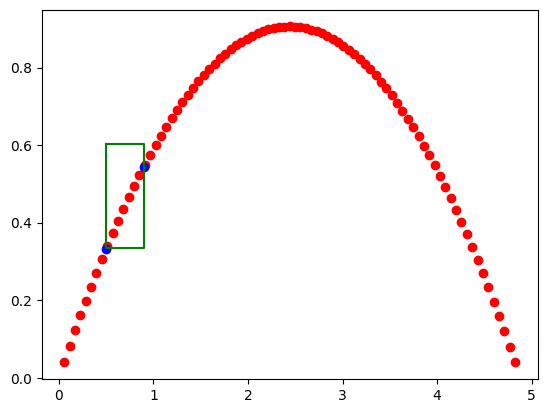

In [48]:
def plotTrajectoryOfObject(angle, velocity, delta_x, min_time, max_time):
  xFunc = returnXFunc(angle, velocity)
  yFunc = returnYFunc(angle, velocity)
  delta_t = 0.01
  t = delta_t
  while yFunc(t) > 0:
    plt.plot(xFunc(t), yFunc(t), 'ro')
    t += delta_t
  plt.plot(xFunc(min_time), yFunc(min_time), 'bo')
  plt.plot(xFunc(max_time), yFunc(max_time), 'bo')
  plt.plot([delta_x - goal_length / 2, delta_x- goal_length / 2, delta_x + goal_length / 2, delta_x + goal_length / 2, delta_x - goal_length / 2], [goal_top - delta_z, goal_bottom-delta_z + goal_height, goal_bottom-delta_z + goal_height, goal_top-delta_z, goal_top-delta_z], "g")
  plt.show()
import random
k = random.randint(0, len(datas) -1)
plotTrajectoryOfObject(datas[k]["angle"], (datas[k]["velocity"][0]), datas[k]["delta_x"],datas[k]["min_times"][0], datas[k]["max_times"][0])

In [ ]:

def returnSolutions(angle, velocity, delta_x, delta_y, goal_height, goal_length):
  min_y = goal_bottom
  max_y = goal_top

  min_x = delta_x - goal_length / 2
  max_x = delta_x + goal_length / 2

  y1 = (solveForTimeY(angle, velocity, min_y))
  y2 = (solveForTimeY(angle, velocity, max_y))

  x1 = (solveForTimeX(angle, velocity, min_x))
  x2 = (solveForTimeX(angle, velocity, max_x))

  time_solutions = [[[x1, x2], [y1[0], y2[0]]], [[x1, x2], [y2[1], y1[1]]]]

  print(time_solutions)
  solutions = []

  plotTrajectoryOfObject(angle, velocity, (delta_x, delta_y))
  
  
  for x, y in time_solutions:
    # If both time solutions are negative then this won't work
    if y[0] == -1 or y[1] == -1:
      continue
    # if y[0] == -1 and y[1] > x[0]:
    #   y[0] = x[0]
    # if y[1] == -1 and y[0] < x[1]:
    #   y[1] = x[1]  

    # Check to see if any time solutions have an overlap area
    # if not ((max(x) >= min(y) and max(y) >= max(x)) or (max(y) >= min(x) and max(x) >= max(y))):
    #   continue

    # if sin(angle) * velocity * min(x) + (1/2 * g) * min(x) * min(x) < goal_top:
    #   continue
    
    # if sin(angle) * velocity * max(x) + (1/2 * g) * max(x) * max(x) < goal_top:
    #   print("Disc above top")
    #   continue
    # Check to see if the disk will be above the goal at start of its trajectory (throw this solution out)

    # if sin(angle) * velocity * min(x) + (1/2 * g) * min(x) * min(x) > max_y:
    #   continue
    
    # if sin(angle) * velocity * max(x) + (1/2 * g) * max(x) * max(x) < sin(angle) * velocity * min(x) + (1/2 * g) * min(x) * min(x):
    #   continue
    
    # print("Minimum x position: ", min(x) * velocity * cos(angle), "Maximum x position: ", max(x) * velocity * cos(angle))
    # print("Minimum y position: ", min(y) * velocity * sin(angle) + (1/2 * g) * (min(y) * min(y)), "Maximum y position: ", max(y) * velocity * sin(angle) + (1/2 * g) * (max(y) * max(y)))

    # print("Minimum x time: ", min(x), "Maximum x time: ", max(x))
    # print("Minimum y time: ", min(y), "Maximum y time: ", max(y))
    if max(y) >= max(x) and min(y) >= min(x):
      solutions.append([min(x), max(x)])
      paths.append(0)
    elif max(y) > min(x) and min(x) >= min(y):
      solutions.append([min(x), max(y)])
      paths.append(1)
    
    elif max(y) >= max(x) and min(y) >= min(x):
      solutions.append([min(x), max(x)])
      paths.append(0)
    elif max(y) > min(x) and min(x) >= min(y):
      solutions.append([min(x), max(y)])
      paths.append(1)

    else:
      raise Exception("This shouldn't happen")
  

    

    # print(f"This works, the disk will hit the goal at: {time_we_gonna_use:.2f} with an initial velocity of {velocity:.2f} m/s")
    # print(velocity * cos(angle) * time_we_gonna_use, velocity * sin(angle) * time_we_gonna_use + 1/2 * g * time_we_gonna_use**2)
  
  return solutions

delta_x = 1
velocity = 10
returnSolutions(angle, velocity, delta_x, delta_z, goal_top, goal_length)

In [ ]:

def computeSolutionsForPosition(angle, delta_x, delta_z):
  v_disk_i = calculateRequiredInitialVelocityToPassThroughAPoint((delta_x, delta_z))

  returnYFunc(v_disk_i, angle)

  solutions = []

  chunk_size = max_flywheel_speed
  min_v_disk_i = calculateRequiredInitialVelocityToPassThroughAPoint((delta_x - goal_length / 2, delta_z - goal_height / 2))
  # print("Minimum velocity for disk to hit goal: ", min_v_disk_i)

  max_disk_i = max_flywheel_speed

  while True:
    solution = (returnSolutions(angle, max_disk_i, delta_x, delta_z, goal_height, goal_length))
    
    # If there are solutions, then half chunk_size and subtract from current v_disk
    if len(solution) == 0:
      chunk_size /= 2
      max_disk_i -= chunk_size
    else:
      chunk_size /= 2
      max_disk_i += chunk_size
    if max_disk_i > max_flywheel_speed:
      max_disk_i = max_flywheel_speed
      break
    if chunk_size < 0.001:
      break

  # print("Maximum velocity for disk to hit goal: ", max_disk_i)

  data = {
    "num_solutions" : 0,
    "velocity" : [],
    "y_velocity_at_goal" : [],
    "min_times" : [],
    "max_times" : [],
  }
  solutions = []
  
  iterations = 100
  for i in range(iterations):
    velocity = (max_disk_i - min_v_disk_i) / iterations * i + min_v_disk_i

    solution = (returnSolutions(angle, velocity, delta_x, delta_z, goal_height, goal_length))
    solutions.extend(solution)
    if len(solution) > 0:
      solution = solution[0]

      data["num_solutions"] += 1
      data["velocity"].append(velocity)
      data["min_times"].append(solution[0])
      data["max_times"].append(solution[1])
      data["y_velocity_at_goal"].append(velocity * sin(angle) + g * solution[1])
      
      # print("velocity of disk: ", velocity)
      pos1 = (velocity * cos(angle) * solution[0], velocity * sin(angle) * solution[0] + 1/2 * g * solution[0]**2)
      pos2 = (velocity * cos(angle) * solution[1], velocity * sin(angle) * solution[1] + 1/2 * g * solution[1]**2)
      # print(f"Disk x will go from {velocity * cos(angle) * solution[0]} to {velocity * cos(angle) * solution[1]} m")
      # print(f"Disk y will go from {solution[0] ** 2 * g / 2 + velocity * sin(angle) * solution[0]} to {solution[1] ** 2 * g / 2 + velocity * sin(angle) * solution[1]}")
      # plt.plot(pos1[0], pos1[1], 'ro')
      # plt.plot(pos2[0], pos2[1], 'bo')

  # print(len(solutions))
  plt.show()
  
  return data

computeSolutionsForPosition(angle, delta_x, delta_z)

In [ ]:
delta_x = 1
calculateRequiredInitialVelocityToPassThroughAPoint((delta_x - goal_length / 2, delta_z - goal_height / 2))

In [ ]:
chunk_size = 7.44
max_disk_i = max_flywheel_speed

while True:
  solution = (returnSolutions(angle, max_disk_i, delta_x, delta_z, goal_height, goal_length))
  print(max_disk_i)
  # If there are solutions, then half chunk_size and subtract from current v_disk
  if len(solution) == 0:
    chunk_size /= 2
    max_disk_i -= 0.1
  else:
    chunk_size /= 2
    max_disk_i += chunk_size
  if max_disk_i > max_flywheel_speed:
    max_disk_i = max_flywheel_speed
    break
  if chunk_size < 0.001:
    break

In [ ]:
velocity = 3.5
min_y = delta_z - goal_height / 2
max_y = delta_z + goal_height / 2

min_x = delta_x - goal_length / 2
max_x = delta_x + goal_length / 2

y1 = (solveForTimeY(angle, velocity, min_y))
y2 = (solveForTimeY(angle, velocity, max_y))

x1 = (solveForTimeX(angle, velocity, min_x))
x2 = (solveForTimeX(angle, velocity, max_x))

time_solutions = [[[x1, x2], [y1[0], y2[0]]], [[x1, x2], [y2[1], y1[1]]]]
solutions = []

for x, y in time_solutions:
  # If both time solutions are negative then this won't work
  if y[0] == -1 and y[1] == -1:
    continue
  if y[0] == -1:
    y[0] = x[0]
  if y[1] == -1:
    y[1] = x[1]  

  print(x, y, (max(x) >= min(y) and max(y) >= max(x)))
  # Check to see if any time solutions have an overlap area
  if not ((max(x) >= min(y) and max(y) >= max(x)) or (max(y) >= min(x) and max(x) >= max(y))):
    continue
  print("wooo")
  # Check to see if the disk will be above the goal at start of its trajectory (throw this solution out)

  if sin(angle) * velocity * min(x) + (1/2 * g) * min(x) * min(x) > max_y:
    continue
  
  # print("Minimum x position: ", min(x) * velocity * cos(angle), "Maximum x position: ", max(x) * velocity * cos(angle))
  # print("Minimum y position: ", min(y) * velocity * sin(angle) + (1/2 * g) * (min(y) * min(y)), "Maximum y position: ", max(y) * velocity * sin(angle) + (1/2 * g) * (max(y) * max(y)))

  # print("Minimum x time: ", min(x), "Maximum x time: ", max(x))
  # print("Minimum y time: ", min(y), "Maximum y time: ", max(y))
  if max(x) <= max(y) and min(x) >= min(y):
    solutions.append([min(x), max(x)])
  elif max(y) <= max(x) and min(y) >= min(x):
    solutions.append([min(y), max(y)])
  elif max(x) >= max(y):
    solutions.append([min(x), max(y)])
  elif max(y) >= max(x):
    solutions.append([min(y), max(x)])
  else:
    raise Exception("This shouldn't happen")
  

  # print(f"This works, the disk will hit the goal at: {time_we_gonna_use:.2f} with an initial velocity of {velocity:.2f} m/s")
  # print(velocity * cos(angle) * time_we_gonna_use, velocity * sin(angle) * time_we_gonna_use + 1/2 * g * time_we_gonna_use**2)

print(solutions)

In [ ]:
returnSolutions(angle, 1, delta_x, delta_z, goal_height, goal_length)